### imports

In [3]:
import kagglehub
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from dotenv import load_dotenv

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    classification_report
    )

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

True

### download & load the dataset

In [4]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print(f"Dataset downloaded to: {path}")
df = pd.read_csv(f"{path}/creditcard.csv")

Dataset downloaded to: /home/yezer/projects/credit-fraud-detector/datasets/datasets/mlg-ulb/creditcardfraud/versions/3


### explore the dataset


In [5]:
print("df.shape", df.shape)
df.head()

df.shape (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
print(f"- total null values:{df.isnull().sum().sum()}")
print(f"- % null values:{df.isnull().sum().sum()*100/df.notnull().sum().sum()}")
print(f"- 99% of transactions are under ${df['Amount'].quantile(0.99):.2f}")
print(f"\n- % fraud transactions:{100*df[df.Class==1].shape[0]/df.shape[0]:.2f}")
print(f"- fraud transactions with amount 0 -> {df[(df.Class==1) & (df.Amount==0.0)].shape[0]}")
print(f"- fraud transactions max amount -> {df[df.Class==1]['Amount'].max()}")
print(f"\n- % correct transactions:{100*df[df.Class==0].shape[0]/df.shape[0]:.2f}")
print(f"- correct transactions with amount 0 -> {df[(df.Class==0) & (df.Amount==0.0)].shape[0]}")
print(f"- correct transactions max amount -> {df[df.Class==0]['Amount'].max()}")


- total null values:0
- % null values:0.0
- 99% of transactions are under $1017.97

- % fraud transactions:0.17
- fraud transactions with amount 0 -> 27
- fraud transactions max amount -> 2125.87

- % correct transactions:99.83
- correct transactions with amount 0 -> 1798
- correct transactions max amount -> 25691.16


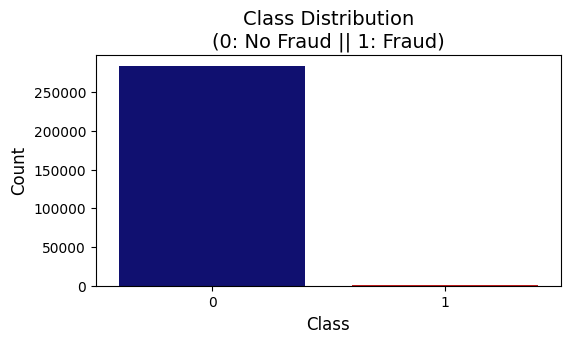

In [8]:
# Plot class distribution
plt.figure(figsize=(6, 3))
colors = ["#000080", "#DF0101"]  # Dark blue for non-fraud, Red for fraud
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distribution\n(0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


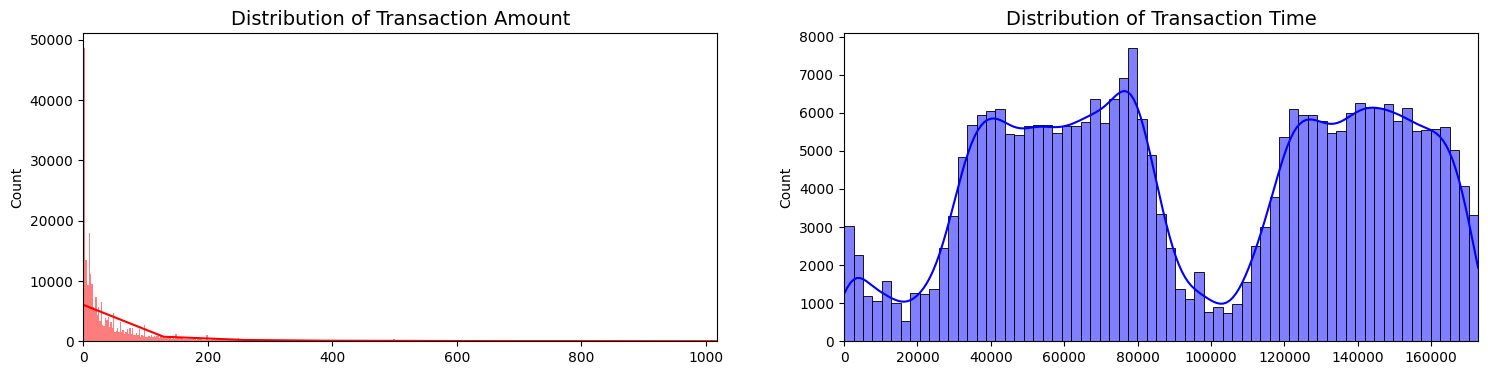

In [9]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['Amount'].values
time_val = df['Time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### scaling

- In this phase of our kernel, we will first scale the columns comprise of Time and Amount .
Time and amount should be scaled as the other columns

In [10]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


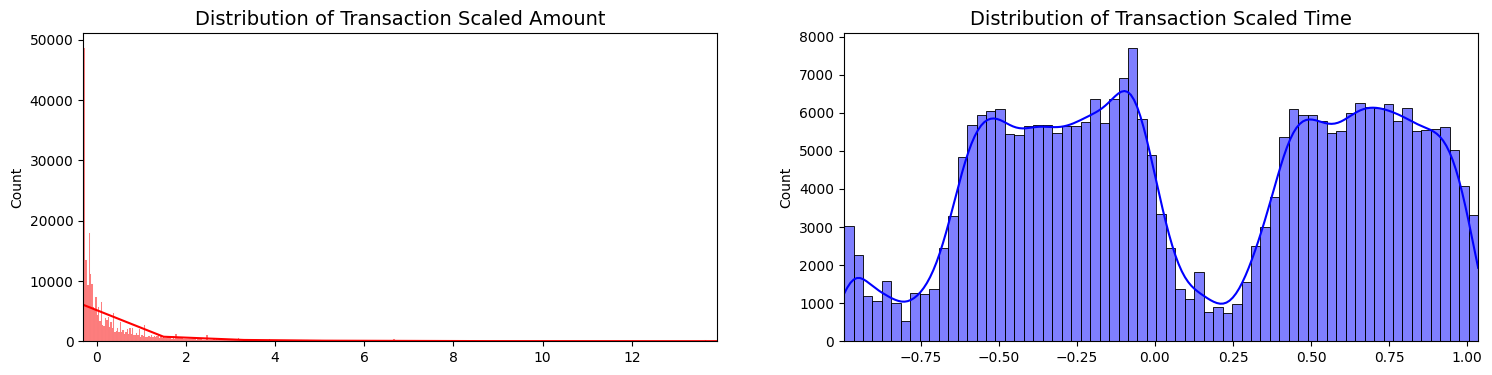

In [11]:
# Create figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Get transaction amounts and times
amount_val = df['scaled_amount'].values
time_val = df['scaled_time'].values

# Plot distribution of transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Scaled Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), np.percentile(amount_val, 99)])  # Limit x-axis to 99th percentile

# Plot distribution of transaction times 
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Scaled Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### baseline model (AUPRC metric)

- Run Cross-Validation Across Multiple Seeds (For Robustness). Try several seeds and observe the distribution of metrics. This tells you how sensitive your model is to random splits. Cross-validation is primarily a technique to get a reliable estimate of how your model will perform on unseen data and to select the best model/hyperparameters. Once you've made that selection, you want your final model to learn from as much data as possible. Training on the full dataset allows the model to see all available examples, which can lead to a potentially more robust and slightly better-performing model.

- Use this to check stability across seeds rather than choosing a single “best” one.

- Once Satisfied, Fix One Seed for Reproducibility

- If the performance is not stable across seeds, your dataset may be:Too small or too noisy or extremely sensitive to the splits.

- What Does AUPRC Measure?
It quantifies the trade-off between:
Precision = How many of the predicted positives are actually positive
Recall = How many of the actual positives are correctly predicted
The Precision-Recall Curve shows this trade-off at all possible classification thresholds (e.g. values over 0.1 are fraud, 02, 0.3, ...). The area under that curve
(AUPRC) summarizes the model’s performance in one number.

- AUPRC is better for imbalanced datasets, however AUC-ROC is better for balanced ones. AUPRC focuses only on the positive class, so it tells you how well the model is identifying the rare events (e.g., hotel reservations in your case), which is what you care about most.

- AUPRC summarizes performance over all thresholds — to actually deploy a model, you still need to choose a specific threshold based on business trade-offs between precision and recall.

- F1 score is a single metric that provides a balanced measure of the model's performance by considering both precision and recall. It is the harmonic mean of precision and recall. F1 Score = 1: This indicates perfect precision and perfect recall. The model correctly identifies all positive instances and makes no incorrect positive predictions. The F1 score is particularly useful when dealing with imbalanced datasets (where one class has significantly more instances than the other).

In [40]:
all_auprc_scores = []
all_f1_scores = []

X = df.drop("Class", axis=1)
y = df["Class"]

for seed in [1, 7, 21, 42, 100, 123]:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold_auprcs = []
    fold_f1s = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LogisticRegression(random_state=seed)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)

        auprc = average_precision_score(y_val, y_pred_proba)
        f1 = f1_score(y_val, y_pred)
        fold_auprcs.append(auprc)
        fold_f1s.append(f1)

    mean_auprc = np.mean(fold_auprcs)
    std_auprc = np.std(fold_auprcs)
    mean_f1 = np.mean(fold_f1s)
    std_f1 = np.std(fold_f1s)
    print(
        f"Seed {seed} - Mean AUPRC: {mean_auprc:.4f} std: {std_auprc:.4f}, Mean F1: {mean_f1:.4f} std: {std_f1:.4f}"
    )
    all_auprc_scores.append((seed, mean_auprc))
    all_f1_scores.append((seed, mean_f1))

Seed 1 - Mean AUPRC: 0.7543 std: 0.0375, Mean F1: 0.7304 std: 0.0215
Seed 7 - Mean AUPRC: 0.7580 std: 0.0511, Mean F1: 0.7213 std: 0.0322
Seed 21 - Mean AUPRC: 0.7598 std: 0.0095, Mean F1: 0.7262 std: 0.0271
Seed 42 - Mean AUPRC: 0.7563 std: 0.0226, Mean F1: 0.7301 std: 0.0321
Seed 100 - Mean AUPRC: 0.7567 std: 0.0495, Mean F1: 0.7226 std: 0.0377
Seed 123 - Mean AUPRC: 0.7559 std: 0.0243, Mean F1: 0.7203 std: 0.0430


In [41]:
# Generate Random Classifier Baseline
# Create random predictions and calculate AUPRC and F1 to compare with our model
random_preds = np.random.random(len(y))
random_preds_binary = (random_preds > 0.5).astype(int)  # Convert to binary predictions for F1
random_auprc = average_precision_score(y, random_preds)
random_f1 = f1_score(y, random_preds_binary)
print(f'\nRandom Classifier AUPRC: {random_auprc:.4f}')
print(f'Random Classifier F1: {random_f1:.4f}')


Random Classifier AUPRC: 0.0018
Random Classifier F1: 0.0034


##### model01 - training logistic reg. with the dataset

Fold 1 - Train AUPRC: 0.7769 - Validation AUPRC: 0.7175
Fold 2 - Train AUPRC: 0.7691 - Validation AUPRC: 0.7598
Fold 3 - Train AUPRC: 0.7608 - Validation AUPRC: 0.7775
Fold 4 - Train AUPRC: 0.7577 - Validation AUPRC: 0.7792
Fold 5 - Train AUPRC: 0.7708 - Validation AUPRC: 0.7478

Mean AUPRC: 0.7563 (+/- 0.0453)

AUPRC on the full dataset (baseline model): 0.7656


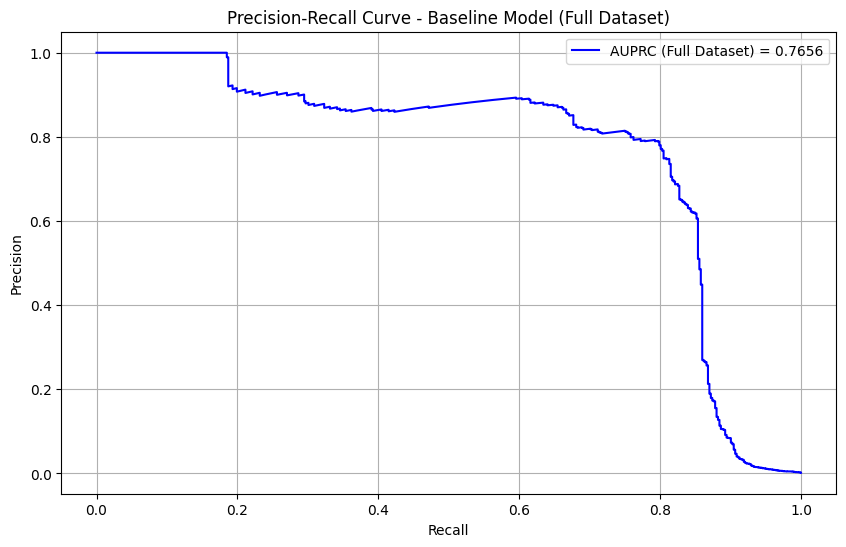

In [42]:
# Prepare data for modeling
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
recall_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    lr_model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)
    
    # Calculate metrics for validation set
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc_val = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc_val) # Store validation AUPRC for mean calculation

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)
    
    print(f'Fold {fold + 1} - Train AUPRC: {auprc_train:.4f} - Validation AUPRC: {auprc_val:.4f}')

print('\nMean AUPRC: {:.4f} (+/- {:.4f})'.format(
    np.mean(auprc_scores), 
    np.std(auprc_scores) * 2
))

# Train model on the entire dataset
lr_model.fit(X, y)

# Get predictions on the entire dataset
y_pred_proba_full = lr_model.predict_proba(X)[:, 1]

# Calculate AUPRC on the entire dataset
auprc_full = average_precision_score(y, y_pred_proba_full)
print(f'\nAUPRC on the full dataset (baseline model): {auprc_full:.4f}')

# Calculate Precision-Recall curve for the full dataset
precision_full, recall_full, _ = precision_recall_curve(y, y_pred_proba_full)

# Plot Precision-Recall curve for the full dataset
plt.figure(figsize=(10, 6))
plt.plot(recall_full, precision_full, color='blue', label=f'AUPRC (Full Dataset) = {auprc_full:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Model (Full Dataset)')
plt.legend()
plt.grid(True)
plt.show()



Optimal threshold for perfect precision: 0.9987
At this threshold:
Precision: 0.9
Recall: 0.2755


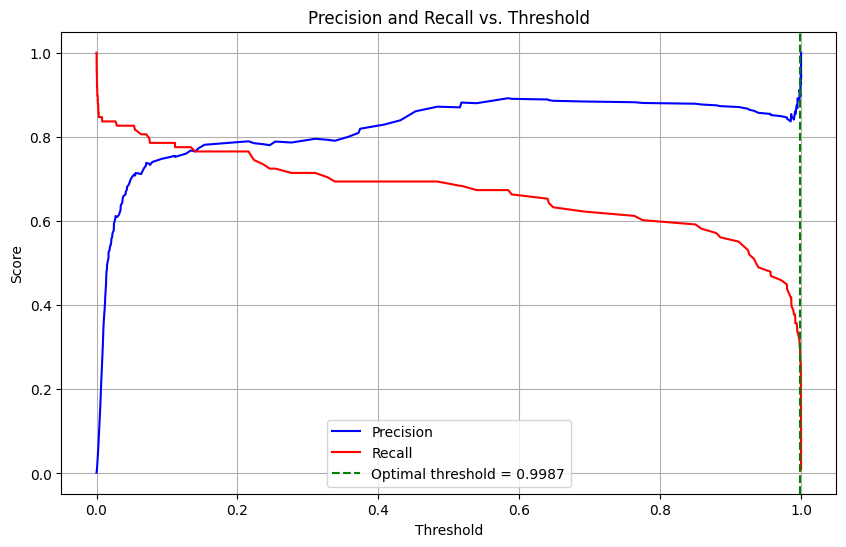

In [46]:
# Get precision-recall curve data from last fold
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Find the largest threshold where precision is still 0.99
# We'll look through the precision values from highest threshold to lowest
max_recall_at_full_precision = 0
optimal_threshold = 1.0
needed_precision = 0.9

for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if p == needed_precision and r > max_recall_at_full_precision:
        max_recall_at_full_precision = r
        optimal_threshold = t

print(f"\nOptimal threshold for perfect precision: {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"Precision: {needed_precision}")
print(f"Recall: {max_recall_at_full_precision:.4f}")

# Plot precision and recall curves vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', 
            label=f'Optimal threshold = {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example of making predictions with a threshold of 0.8
# Let's simulate some new transaction data (using the same features as training data)
new_transaction = X.iloc[0:1]  # Using first row as example new transaction
print(f"fraud: {y.iloc[0:1].values}")

# Get probability predictions 
# Get probability predictions from logistic regression model
# predict_proba returns probabilities for both classes [P(class=0), P(class=1)]
# We take [:, 1] to get only the probability of fraud (class 1)
pred_proba = lr_model.predict_proba(new_transaction)[:, 1]  # Returns probability of fraud between 0 and 1
print(pred_proba)

# Apply threshold of 0.8
threshold = 0.8
prediction = (pred_proba >= threshold).astype(int)

print("Probability of fraud:", pred_proba[0])
print(f"Prediction (threshold={threshold}):", prediction[0])
print("Actual prediction would be fraud" if prediction[0] == 1 else "Actual prediction would be legitimate")


### Random undersampling technique

- "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

- we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and
Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction
is a fraud or not.

- What is a sub-Sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

- What happens if a sub-sample (or another technique) is not used?
    - Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    -Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

- Random undersampling. There are 492 cases of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. We concat the 492 cases of fraud and non fraud, creating a new sub-sample.

In [47]:
fraud_cases = df[(df.Class==1)].shape[0]
print(f"fraud cases: {fraud_cases}")


fraud cases: 492


- Before proceed with Random Undersampling, we have to separate the original dataframe for testing purposes, we need to test all the techniques we try over the original deataset. We train over oversampling or undersampling dataset and test over the original dataset.

In [48]:
X = df.drop('Class', axis=1)
y = df['Class']

# StratifiedKFold splits the data into 5 folds while maintaining the same ratio of classes
# (fraud/non-fraud) in each fold
# n_splits=5: Creates 5 different train/test splits
# random_state=42: Set random seed for reproducible results each time
# shuffle=False: Data is not shuffled before splitting
# random_state only has an effect when shuffle=True, since it controls the randomization
# if shuffle=False, the data stays in original order so random_state would have no effect
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# example of folding without keeping ratio.
# sss = KFold(n_splits=5, random_state=None, shuffle=False)

# We actually only need the last split from the StratifiedKFold
# The loop was just printing statistics about each fold to verify the stratification
i = 1
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    # print(f"% frauds in train set: {(original_ytrain == 1).mean() * 100:.4f}%")
    # print(f"% frauds in test set: {(original_ytest == 1).mean() * 100:.4f}%")
    i+=1

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


# Check distribution of labels in train and test sets
print("\nLabel distribution in full dataset:")
print(pd.Series(y).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')
print("\nLabel distribution in training set:")
print(pd.Series(original_ytrain).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')
print("\nLabel distribution in test set:")
print(pd.Series(original_ytest).value_counts(normalize=True).mul(100).round(4).astype(str) + '%')



Label distribution in full dataset:
Class
0    99.8273%
1     0.1727%
Name: proportion, dtype: object

Label distribution in training set:
0    99.8271%
1     0.1729%
Name: proportion, dtype: object

Label distribution in test set:
0    99.828%
1     0.172%
Name: proportion, dtype: object


- Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

- Lets shuffle the data before creating the subsamples

In [49]:
# sample -> This is a pandas DataFrame method used to get a random sample of items from an axis of an object.
# frac=1: This argument specifies the fraction of rows to return in the random sample.
# frac=1 means that 100% of the rows will be returned, effectively shuffling the entire DataFrame.
df = df.sample(frac=1)
print(f"df.shape: {df.shape}")

# amount of fraud classes fraud_cases rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:fraud_df.shape[0]]
print(f"fraud_df.shape: {fraud_df.shape}")
# Get the number of fraud cases
print(f"non_fraud_df.shape: {non_fraud_df.shape}")

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
balanced_df = normal_distributed_df.sample(frac=1, random_state=42)

print(f"balanced_df.shape: {balanced_df.shape}")
balanced_df.head()

df.shape: (284807, 31)
fraud_df.shape: (492, 31)
non_fraud_df.shape: (492, 31)
balanced_df.shape: (984, 31)


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
89431,0.633131,-0.259824,0.974700,-0.956996,1.490097,0.474495,-1.290798,1.248123,-1.284833,0.583325,...,-0.008005,-0.028082,0.270264,-0.106748,-0.181975,0.175866,1.156613,0.005694,0.010555,0
74507,1.515266,-0.341569,-7.427924,2.948209,-8.678550,5.185303,-4.761090,-0.957095,-7.773380,0.717309,...,-0.123085,-0.299847,0.610479,0.789023,-0.564512,0.201196,-0.111225,1.144599,0.102280,1
183857,-0.167819,0.485074,2.038637,0.017005,-1.046122,0.401935,0.005422,-1.092570,0.276714,-0.391442,...,-0.123592,-0.262197,-0.564237,0.322781,0.025830,-0.268717,0.195460,-0.059884,-0.056039,0
79525,-0.293440,-0.312880,-2.630598,5.125759,-6.092255,5.527393,1.605145,-2.319884,-3.207076,-1.482583,...,0.948864,-0.527474,0.220546,-1.371110,-0.504899,0.382307,0.395528,0.782036,0.628528,1
189701,0.996996,0.514891,-4.599447,2.762540,-4.656530,5.201403,-2.470388,-0.357618,-3.767189,0.061466,...,-1.000658,1.581480,0.261333,0.621415,0.994110,-0.687853,-0.337531,-1.612791,1.231425,1


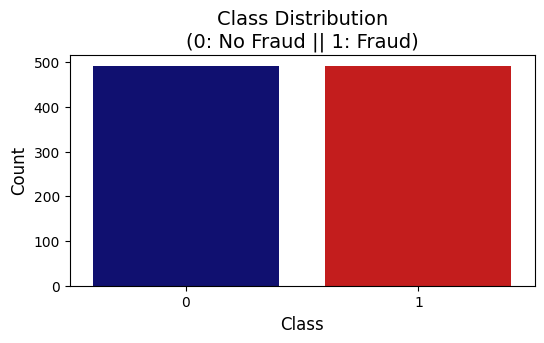

In [50]:
plt.figure(figsize=(6, 3))
colors = ["#000080", "#DF0101"]  # Dark blue for non-fraud, Red for fraud
sns.countplot(x='Class', data=balanced_df, palette=colors)
plt.title('Class Distribution\n(0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


##### model 02 - training logistic reg. with balanced dataset

Fold 1 - Val AUPRC: 0.8049, Train AUPRC: 0.6952
Fold 2 - Val AUPRC: 0.5306, Train AUPRC: 0.5870
Fold 3 - Val AUPRC: 0.7472, Train AUPRC: 0.7155
Fold 4 - Val AUPRC: 0.5101, Train AUPRC: 0.5297
Fold 5 - Val AUPRC: 0.6486, Train AUPRC: 0.7150

Mean AUPRC: 0.6483 (+/- 0.2320)

Training final model with all balanced data...

Final Model AUPRC on original imbalanced dataset: 0.7174


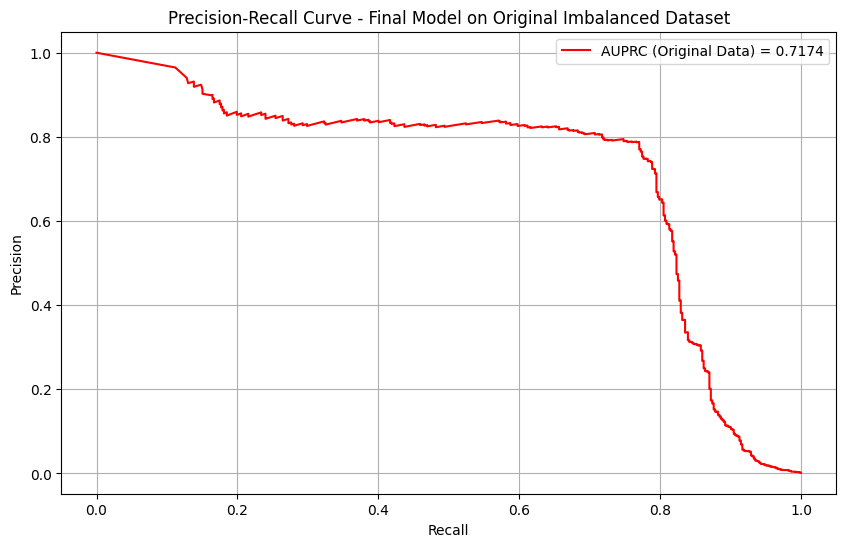

In [51]:
X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]
X_orig = df.drop("Class", axis=1)
y_orig = df["Class"]

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)): # train_idx, val_idx are positional for X, y
    # Get the balanced train/val sets. X and y are from balanced_df, 
    # so X.iloc and y.iloc will retain original DataFrame indices.
    X_train_b = X.iloc[train_idx]
    y_train_b = y.iloc[train_idx]
    X_val_b = X.iloc[val_idx]
    y_val_b = y.iloc[val_idx]

    # Identify indices of data in the original df (X_orig, y_orig) that are not in balanced_df (X, y)
    # X.index contains the original_df indices that are part of balanced_df
    original_df_indices = X_orig.index
    balanced_df_indices_in_original_df = X.index 
    
    remaining_indices = original_df_indices.difference(balanced_df_indices_in_original_df)
    
    X_remaining = X_orig.loc[remaining_indices]
    y_remaining = y_orig.loc[remaining_indices]

    # Split the remaining data (X_remaining, y_remaining) according to the same fold structure
    # This ensures that the remaining data is allocated to train/validation sets for the current fold
    # in a way that is consistent with the overall k-fold strategy.
    if not X_remaining.empty:
        # Create a StratifiedKFold for the remaining data, using the same parameters as the main skf
        skf_remaining = StratifiedKFold(n_splits=skf.get_n_splits(), 
                                        shuffle=skf.shuffle, 
                                        random_state=skf.random_state)
        
        # Iterate through splits of X_remaining to find the one corresponding to the current 'fold'
        # The skf_remaining.split yields positional indices relative to X_remaining.
        gen_rem_splits = skf_remaining.split(X_remaining, y_remaining)
        for i, (train_indices_rem_pos, val_indices_rem_pos) in enumerate(gen_rem_splits):
            if i == fold:
                X_train_rem = X_remaining.iloc[train_indices_rem_pos]
                y_train_rem = y_remaining.iloc[train_indices_rem_pos]
                X_val_rem = X_remaining.iloc[val_indices_rem_pos]
                y_val_rem = y_remaining.iloc[val_indices_rem_pos]
                break
        else:
            # This case should ideally not be reached if 'fold' is always < n_splits.
            # Define empty structures as a fallback.
            X_train_rem = pd.DataFrame(columns=X_train_b.columns)
            y_train_rem = pd.Series(dtype=y_train_b.dtype, name=y_train_b.name if hasattr(y_train_b, 'name') else None)
            X_val_rem = pd.DataFrame(columns=X_val_b.columns)
            y_val_rem = pd.Series(dtype=y_val_b.dtype, name=y_val_b.name if hasattr(y_val_b, 'name') else None)
            
    else: # If X_remaining is empty (e.g., if balanced_df was the same as df)
        X_train_rem = pd.DataFrame(columns=X_train_b.columns)
        y_train_rem = pd.Series(dtype=y_train_b.dtype, name=y_train_b.name if hasattr(y_train_b, 'name') else None)
        X_val_rem = pd.DataFrame(columns=X_val_b.columns)
        y_val_rem = pd.Series(dtype=y_val_b.dtype, name=y_val_b.name if hasattr(y_val_b, 'name') else None)

    # Concatenate the balanced parts with their corresponding parts from the remaining data.
    # The resulting X_train, y_train, X_val, y_val represent the split of the *original* dataset (df)
    # for the current fold, ensuring that the balanced samples (X_train_b, etc.) are included
    # and the overall class proportions mirror a stratified split of the original df.
    X_train = pd.concat([X_train_b, X_train_rem])
    y_train = pd.concat([y_train_b, y_train_rem])
    X_val = pd.concat([X_val_b, X_val_rem])
    y_val = pd.concat([y_val_b, y_val_rem])

    # Train model
    lr_model.fit(X_train_b, y_train_b)

    # Get predictions in balanced dataset.
    # Validation must remain original.
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)

    # Calculate metrics - balanced
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc)

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)

    print(f"Fold {fold + 1} - Val AUPRC: {auprc:.4f}, Train AUPRC: {auprc_train:.4f}")

print(
    "\nMean AUPRC: {:.4f} (+/- {:.4f})".format(
        np.mean(auprc_scores), np.std(auprc_scores) * 2
    )
)

print("\nTraining final model with all balanced data...")
lr_model.fit(X, y)

# Evaluate on the original imbalanced dataset
y_pred_proba_orig = lr_model.predict_proba(X_orig)[:, 1]
auprc_orig_final = average_precision_score(y_orig, y_pred_proba_orig)
precision_orig, recall_orig, _ = precision_recall_curve(y_orig, y_pred_proba_orig)

print(f"\nFinal Model AUPRC on original imbalanced dataset: {auprc_orig_final:.4f}")

# Plot Precision-Recall curve for the final model on original data
plt.figure(figsize=(10, 6))
plt.plot(recall_orig, precision_orig, color="red", label=f"AUPRC (Original Data) = {auprc_orig_final:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Final Model on Original Imbalanced Dataset")
plt.legend()
plt.grid(True)
plt.show()


It is clear, the model trained with balanced dataset can't handle well the original data

### Anomaly detection

The key idea is remove in the samples, the extreme outliers in the features to see the model in the original dataset improves

- Correlation matrices
We want to know if there are features that influence heavily in whether a specific transaction is a fraud. With the whole dataset is not possible to detect correlations due to the umbalancing.

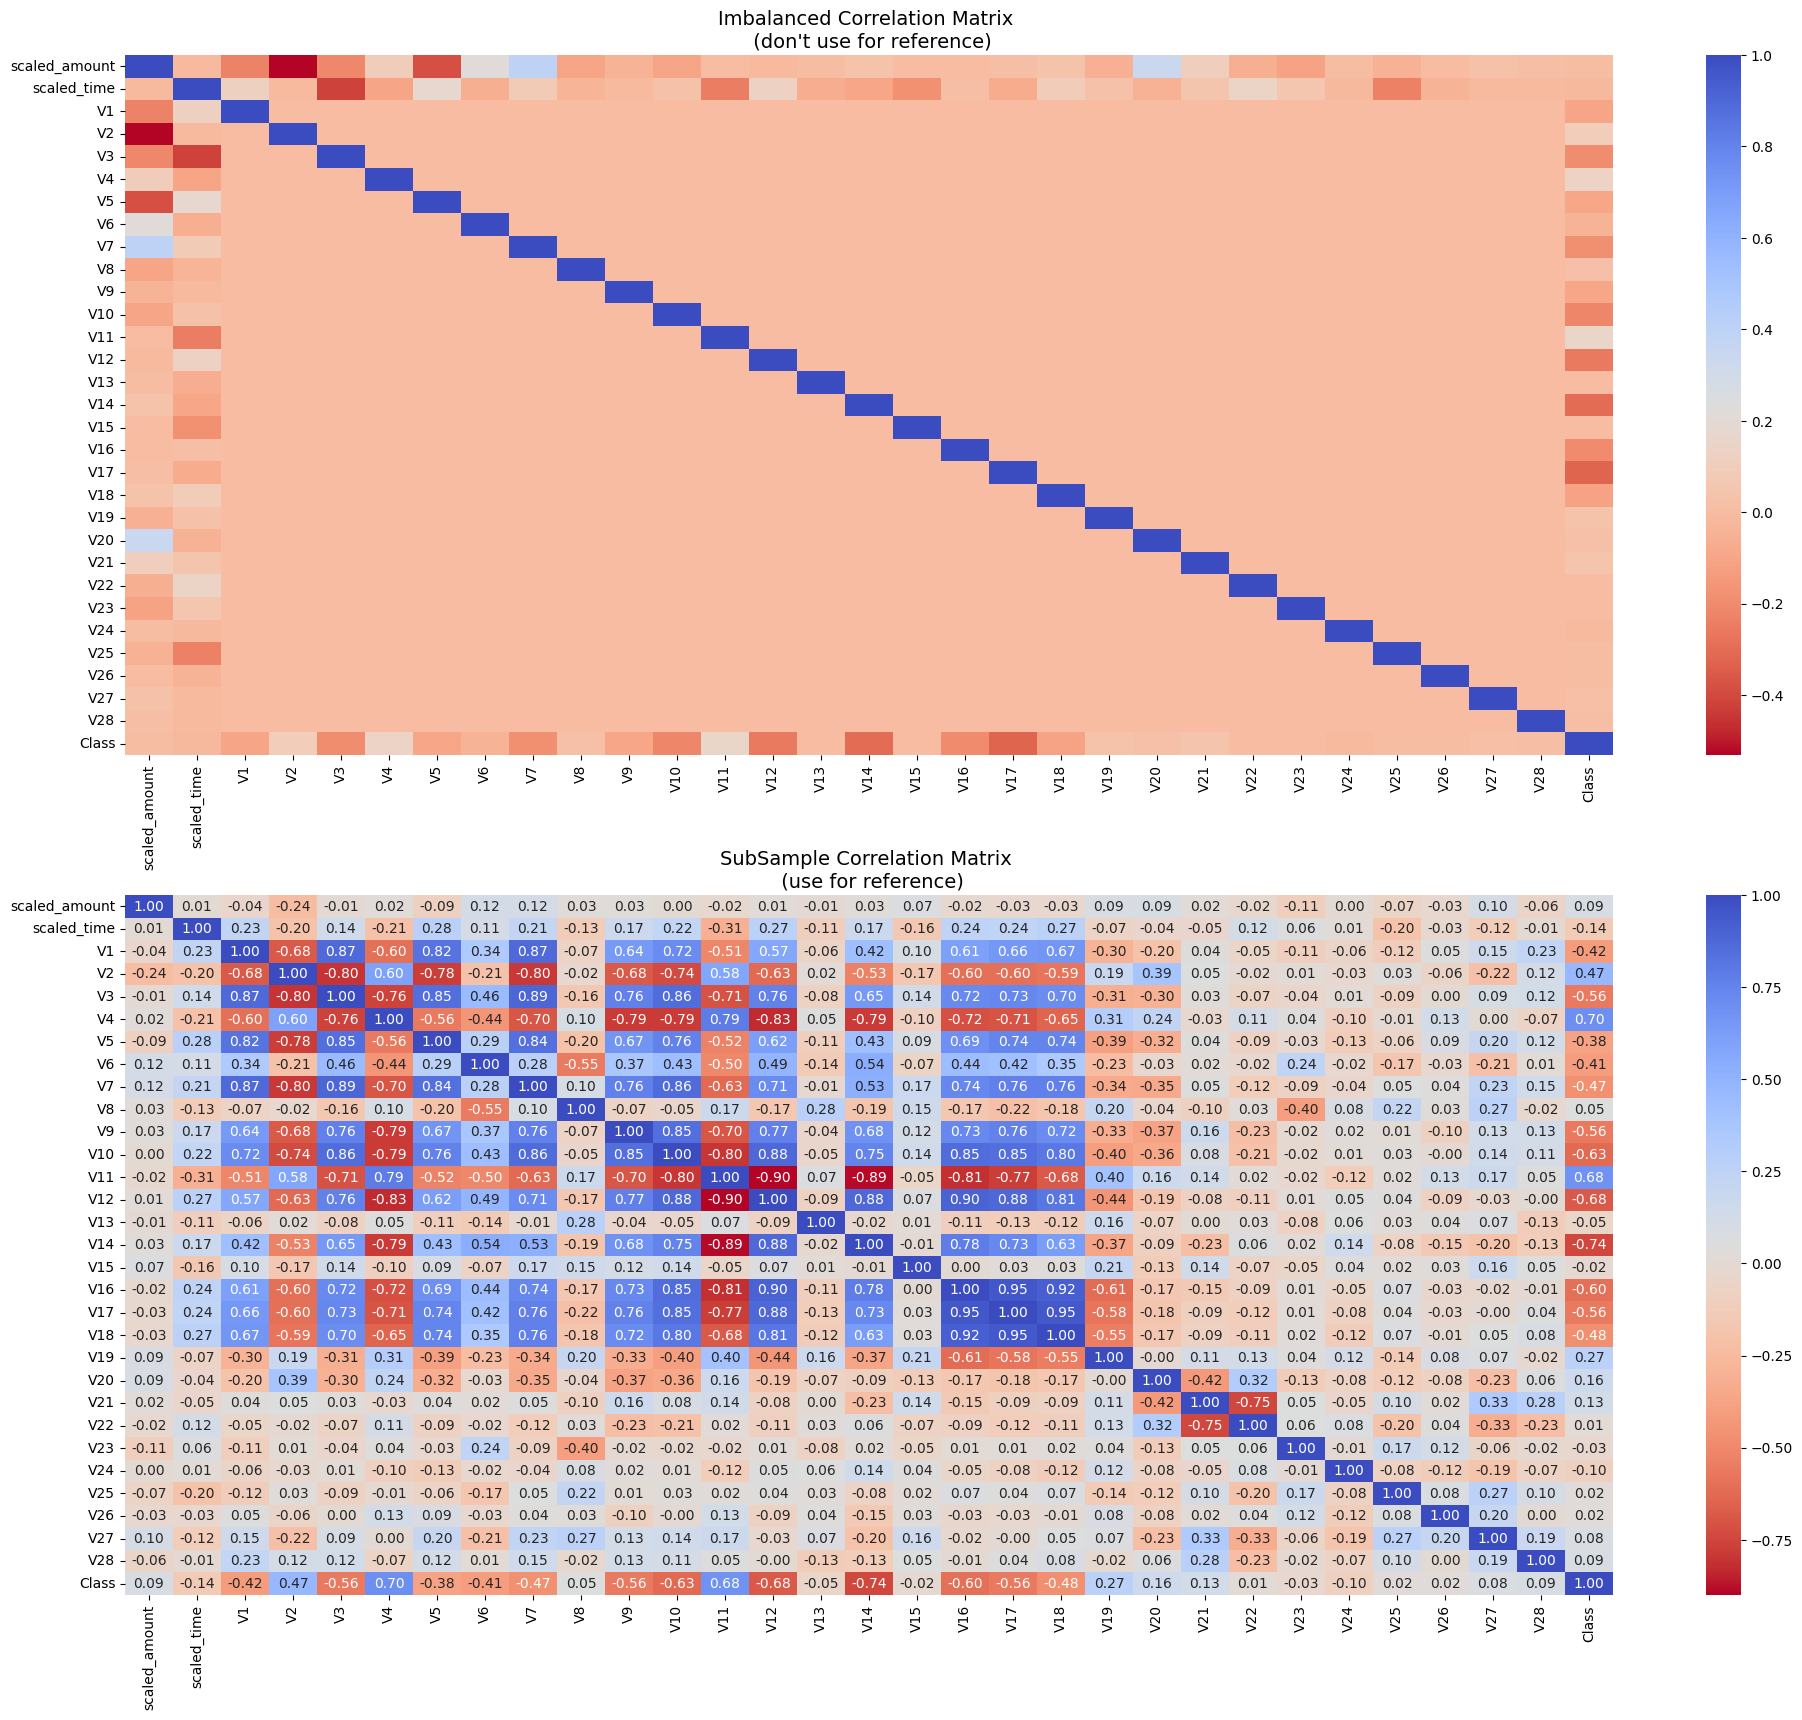

In [52]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = balanced_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax2, annot=True, fmt=".2f")
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Matrices analysis
- When v14, v12, v10 & v16 decrease Class increases ->  Notice how the lower these values are, the more likely the end result will be a fraud transaction
- When v4 & v11 increase, Class increases -> Notice how the higher these values are, the more likely the end result will be a fraud transaction.
- Notice in the original dataset it is difficult to see any correlation.

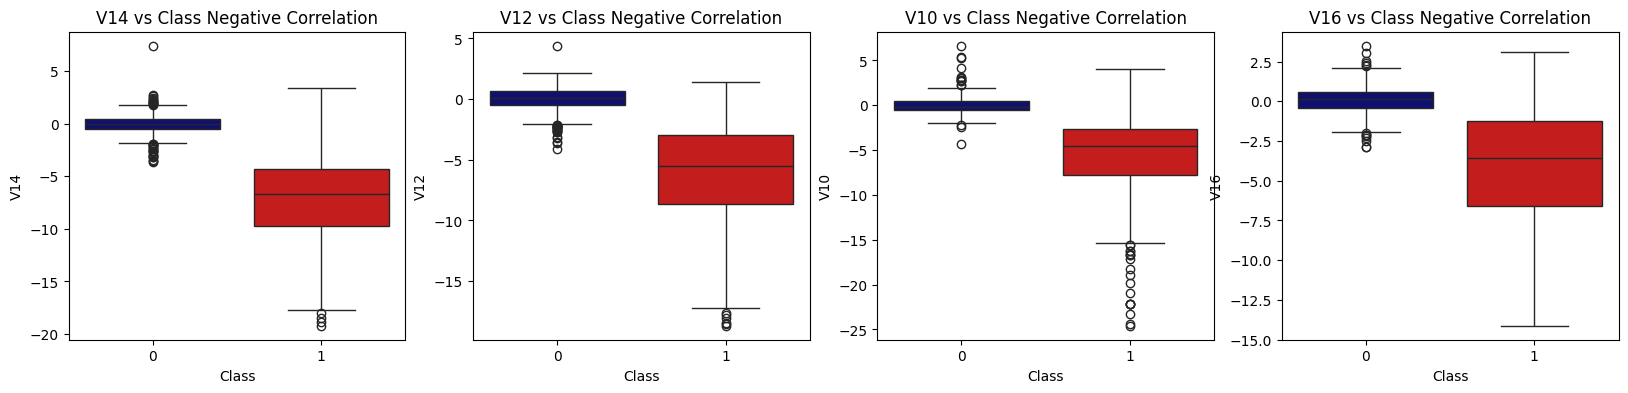

In [53]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V10", data=balanced_df, palette=colors, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=balanced_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

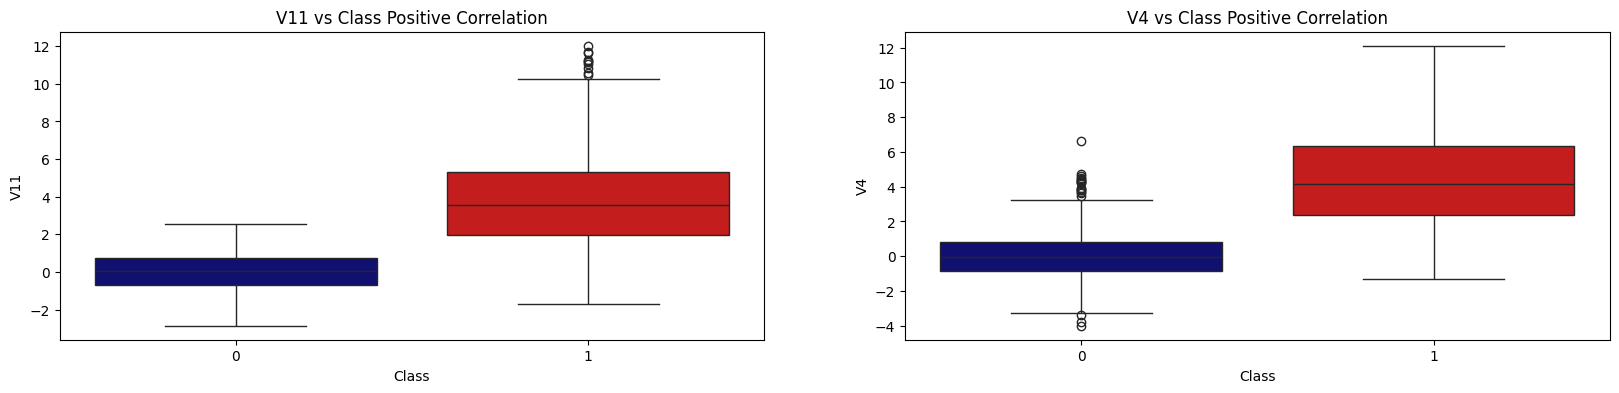

In [54]:

f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

plt.show()

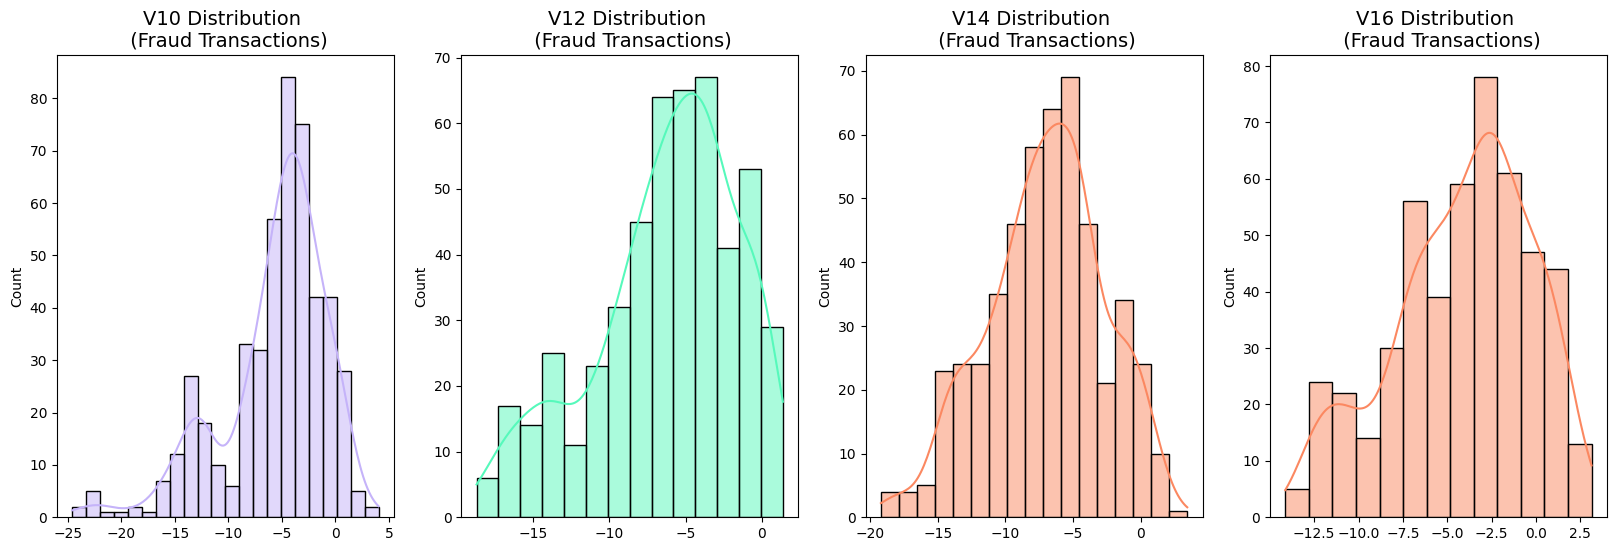

In [55]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v10_fraud_dist = balanced_df['V10'].loc[balanced_df['Class'] == 1].values
sns.histplot(v10_fraud_dist,ax=ax1, kde=True, color='#C5B3F9')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = balanced_df['V12'].loc[balanced_df['Class'] == 1].values
sns.histplot(v12_fraud_dist,ax=ax2, kde=True, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = balanced_df['V14'].loc[balanced_df['Class'] == 1].values
sns.histplot(v14_fraud_dist, ax=ax3, color='#FB8861', kde=True)
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = balanced_df['V16'].loc[balanced_df['Class'] == 1].values
sns.histplot(v16_fraud_dist, ax=ax4, color='#FB8861', kde=True)
ax4.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

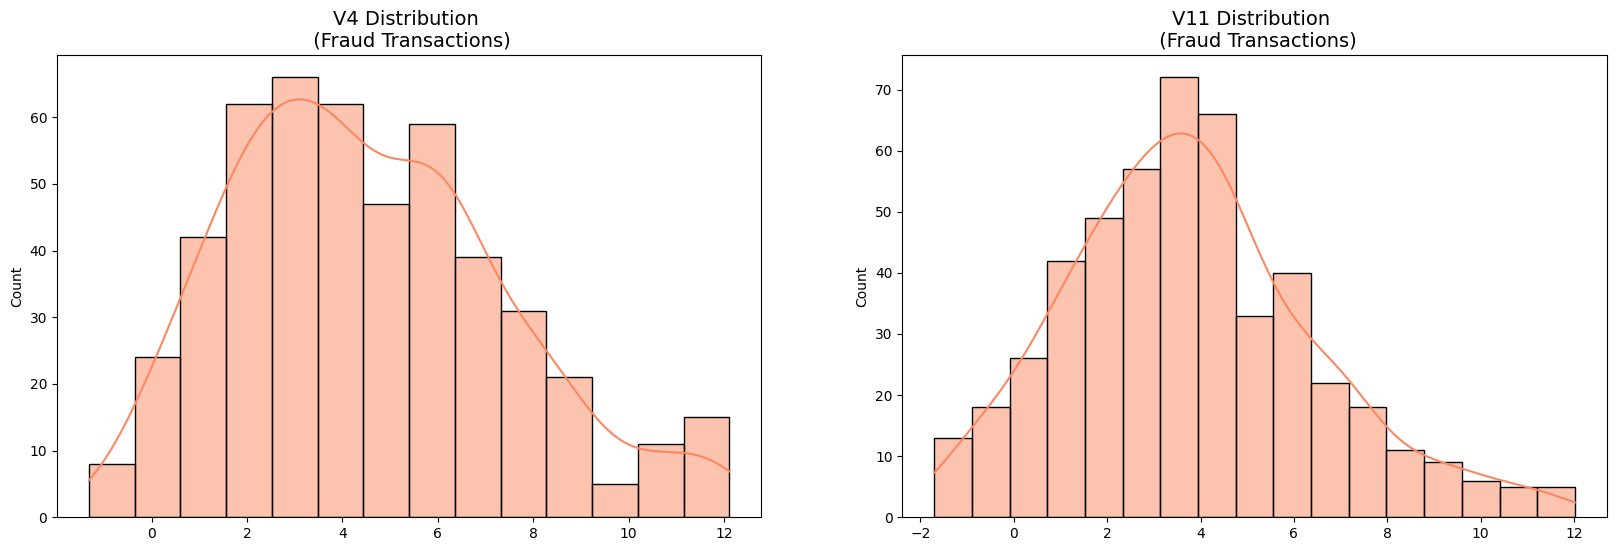

In [56]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

v4_fraud_dist = balanced_df['V4'].loc[balanced_df['Class'] == 1].values
sns.histplot(v4_fraud_dist, ax=ax1, color='#FB8861', kde=True)
ax1.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v11_fraud_dist = balanced_df['V11'].loc[balanced_df['Class'] == 1].values
sns.histplot(v11_fraud_dist, ax=ax2, color='#FB8861', kde=True)
ax2.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Removing extreme outliers

In [57]:
print(f"number of frauds: {balanced_df[(balanced_df.Class==1)].shape[0]}")

v14_fraud = balanced_df["V14"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
v14_non_fraud = balanced_df["V14"].loc[balanced_df["Class"] == 0].values
v14_non_fraud_max = np.max(v14_non_fraud)
v14_non_fraud_min = np.min(v14_non_fraud)
print(
    "iqr V14: {}".format(v14_iqr),
    f"v14_cut_off: {v14_cut_off}",
)

v10_fraud = balanced_df["V10"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
v10_non_fraud = balanced_df["V10"].loc[balanced_df["Class"] == 0].values
v10_non_fraud_max = np.max(v10_non_fraud)
v10_non_fraud_min = np.min(v10_non_fraud)
print("iqr V10: {}".format(v10_iqr), f"v10_cut_off: {v10_cut_off}")

v12_fraud = balanced_df["V12"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
v12_non_fraud = balanced_df["V12"].loc[balanced_df["Class"] == 0].values
v12_non_fraud_max = np.max(v12_non_fraud)
v12_non_fraud_min = np.min(v12_non_fraud)
print("iqr V12: {}".format(v12_iqr), f"v12_cut_off: {v12_cut_off}")

v16_fraud = balanced_df["V16"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
v16_iqr = q75 - q25
v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off

v16_non_fraud = balanced_df["V16"].loc[balanced_df["Class"] == 0].values
v16_non_fraud_max = np.max(v16_non_fraud)
v16_non_fraud_min = np.min(v16_non_fraud)
print("iqr V16: {}".format(v16_iqr), f"v16_cut_off: {v16_cut_off}")

v4_fraud = balanced_df["V4"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25
v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
v4_non_fraud = balanced_df["V4"].loc[balanced_df["Class"] == 0].values
v4_non_fraud_max = np.max(v4_non_fraud)
v4_non_fraud_min = np.min(v4_non_fraud)
print("iqr V4: {}".format(v4_iqr), f"v4_cut_off: {v4_cut_off}")

v11_fraud = balanced_df["V11"].loc[balanced_df["Class"] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25
v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
v11_non_fraud = balanced_df["V11"].loc[balanced_df["Class"] == 0].values
v11_non_fraud_max = np.max(v11_non_fraud)
v11_non_fraud_min = np.min(v11_non_fraud)
print("iqr V11: {}".format(v11_iqr), f"v11_cut_off: {v11_cut_off}")

balanced_df_outliers = balanced_df.copy()

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V14"] > v14_upper) & (v14_upper > v14_non_fraud_max))
        | ((balanced_df_outliers["V14"] < v14_lower) & (v14_lower < v14_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V10"] > v10_upper) & (v10_upper > v10_non_fraud_max))
        | ((balanced_df_outliers["V10"] < v10_lower) & (v10_lower < v10_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V12"] > v12_upper) & (v12_upper > v12_non_fraud_max))
        | ((balanced_df_outliers["V12"] < v12_lower) & (v12_lower < v12_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V16"] > v16_upper) & (v16_upper > v16_non_fraud_max))
        | ((balanced_df_outliers["V16"] < v16_lower) & (v16_lower < v16_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V4"] > v4_upper) & (v4_upper > v4_non_fraud_max))
        | ((balanced_df_outliers["V4"] < v4_lower) & (v4_lower < v4_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

balanced_df_outliers = balanced_df_outliers.drop(
    balanced_df_outliers[
        ((balanced_df_outliers["V11"] > v11_upper) & (v11_upper > v11_non_fraud_max))
        | ((balanced_df_outliers["V11"] < v11_lower) & (v11_lower < v11_non_fraud_min))
    ].index
)
print(
    f"number of frauds: {balanced_df_outliers[(balanced_df_outliers.Class==1)].shape[0]}"
)

number of frauds: 492
iqr V14: 5.409902115485521 v14_cut_off: 8.114853173228282
iqr V10: 5.142514314657911 v10_cut_off: 7.713771471986866
iqr V12: 5.714088496427376 v12_cut_off: 8.571132744641064
iqr V16: 5.336871998040352 v16_cut_off: 8.005307997060529
iqr V4: 3.9756799248685306 v4_cut_off: 5.963519887302796
iqr V11: 3.33368093948933 v11_cut_off: 5.000521409233995
number of frauds: 488
number of frauds: 469
number of frauds: 465
number of frauds: 465
number of frauds: 465
number of frauds: 459


Training with the original dataset without the outliers

In [58]:
df = df.sample(frac=1)
print(f"df.shape: {df.shape}")

# amount of fraud classes fraud_cases rows.
non_fraud_df = df.loc[df['Class'] == 0].copy()
print(f"non_fraud_df.shape: {non_fraud_df.shape}")

fraud_df = balanced_df_outliers[(balanced_df_outliers.Class==1)].copy()
print(f"fraud_df.shape: {fraud_df.shape}")

modif_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
modif_df = modif_df.sample(frac=1, random_state=42)
print(f"modif_df.shape: {modif_df.shape}")

df.shape: (284807, 31)
non_fraud_df.shape: (284315, 31)
fraud_df.shape: (459, 31)
modif_df.shape: (284774, 31)


Fold 1 - Val AUPRC: 0.7270, Train AUPRC: 0.7343
Fold 2 - Val AUPRC: 0.7678, Train AUPRC: 0.7235
Fold 3 - Val AUPRC: 0.6927, Train AUPRC: 0.7525
Fold 4 - Val AUPRC: 0.7521, Train AUPRC: 0.7292
Fold 5 - Val AUPRC: 0.7057, Train AUPRC: 0.7381

Mean AUPRC: 0.7291 (+/- 0.0559)

Training final model with all data...

Final Model AUPRC on original imbalanced dataset: 0.7672


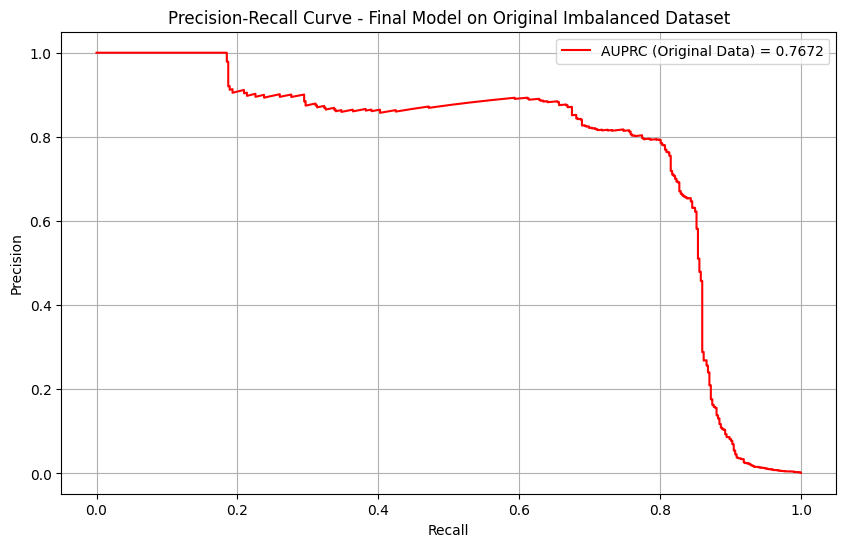

In [61]:
X = modif_df.drop("Class", axis=1)
y = modif_df["Class"]
X_orig = df.drop("Class", axis=1)
y_orig = df["Class"]

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split balanced data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    lr_model.fit(X_train, y_train)

    # Get predictions in balanced dataset
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)

    # Calculate metrics - balanced
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    auprc = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc)

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)

    print(f"Fold {fold + 1} - Val AUPRC: {auprc:.4f}, Train AUPRC: {auprc_train:.4f}")

print(
    "\nMean AUPRC: {:.4f} (+/- {:.4f})".format(
        np.mean(auprc_scores), np.std(auprc_scores) * 2
    )
)

print("\nTraining final model with all data...")
lr_model.fit(X, y)

# Evaluate on the original imbalanced dataset
y_pred_proba_orig = lr_model.predict_proba(X_orig)[:, 1]
auprc_orig_final = average_precision_score(y_orig, y_pred_proba_orig)
precision_orig, recall_orig, _ = precision_recall_curve(y_orig, y_pred_proba_orig)

print(f"\nFinal Model AUPRC on original imbalanced dataset: {auprc_orig_final:.4f}")

# Plot Precision-Recall curve for the final model on original data
plt.figure(figsize=(10, 6))
plt.plot(recall_orig, precision_orig, color="red", label=f"AUPRC (Original Data) = {auprc_orig_final:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Final Model on Original Imbalanced Dataset")
plt.legend()
plt.grid(True)
plt.show()

- The model has improved a little bit in the original imbalanced dataset but is not enough. Maybe downsampling technique in this case is not enough.
- However in the k-fold over modified df the average AUPRC is less.
- The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

##### Dimensionality Reduction & Clustering
We do this over the balanced_df_outliers, to understand how these techniques can help us.

T-SNE took 1.0 s


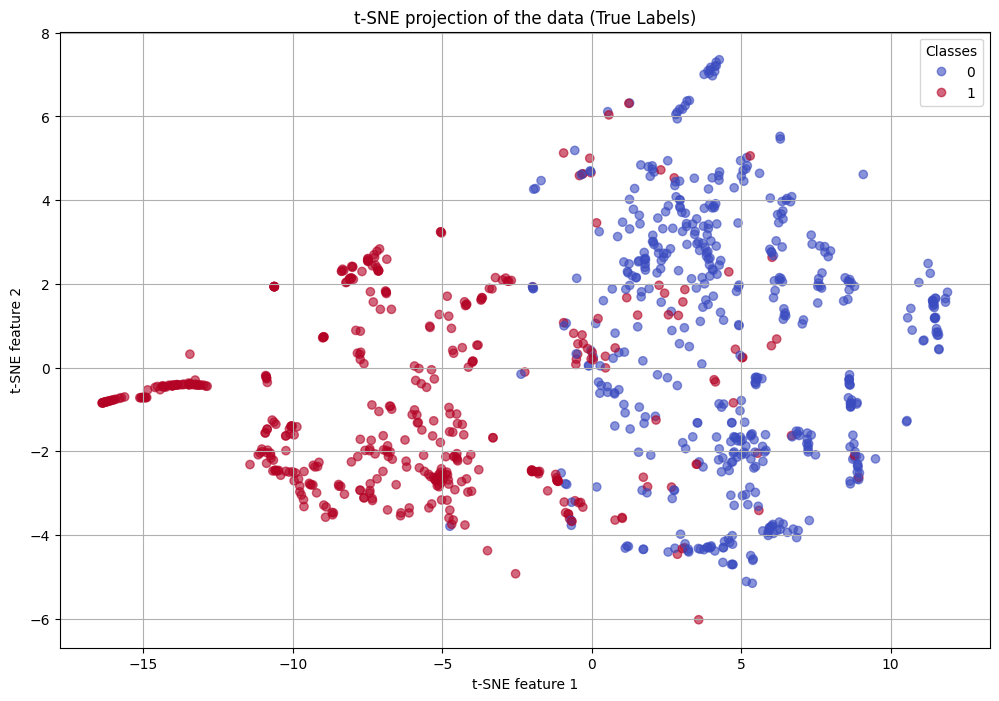

PCA took 0.01 s
Truncated SVD took 0.0027 s


In [62]:
# New_df is from the random undersample data (fewer instances)
X = balanced_df_outliers.drop('Class', axis=1)
y = balanced_df_outliers['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=300).fit_transform(X.values) # Adjusted perplexity and n_iter for potentially better visualization on smaller datasets
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# Plotting T-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE projection of the data (True Labels)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()



# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))


If a clustering technique is able to separating fraud cases, this is a good indicator that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

### oversampling (smote)
- Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.
- Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.
- Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.
- In our undersample analysis I want to show you a common mistake I made that I want to share with all of you. It is simple, if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. In the following section you will see amazing precision and recall scores but in reality our data is overfitting!




![alternative text](images/9101820.jpg)

As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.

##### model 03 - logistic regression with smote

Fold 1 - Train AUPRC: 0.7620 - Validation AUPRC: 0.7278
Fold 2 - Train AUPRC: 0.7614 - Validation AUPRC: 0.7479
Fold 3 - Train AUPRC: 0.7545 - Validation AUPRC: 0.7498
Fold 4 - Train AUPRC: 0.7543 - Validation AUPRC: 0.7827
Fold 5 - Train AUPRC: 0.7636 - Validation AUPRC: 0.7481

Mean AUPRC: 0.7513 (+/- 0.0353)

AUPRC on the full dataset (baseline model): 0.7601


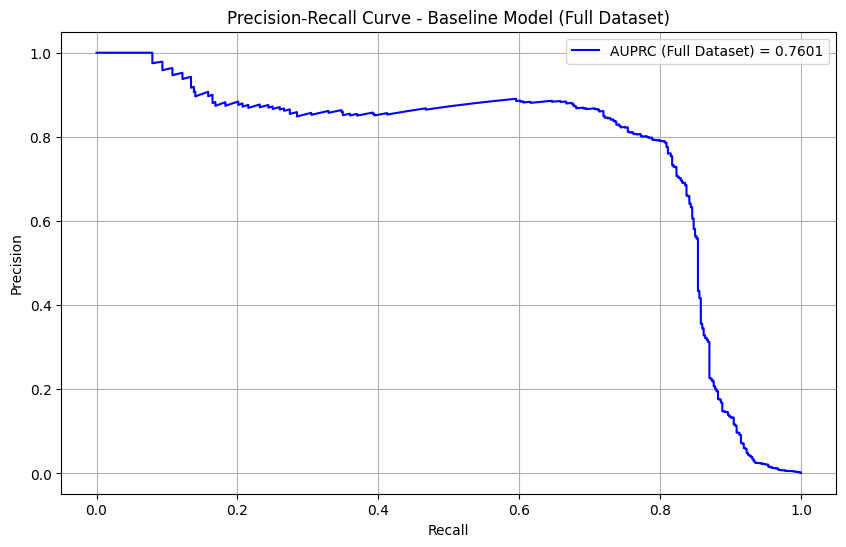

In [ ]:
# Prepare data for modeling
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression as baseline model
lr_model = LogisticRegression(random_state=42)

# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
recall_scores = []
auprc_scores = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] 

    # Apply SMOTE to the training data
    # I want to apply smote only in X_train and y_train to increase the minority class
    smote = SMOTE(random_state=42, sampling_strategy=0.1)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train model
    lr_model.fit(X_train_smote, y_train_smote)
    
    # Get predictions
    y_pred_proba = lr_model.predict_proba(X_val)[:, 1]
    y_pred = lr_model.predict(X_val)
    
    # Calculate metrics for validation set
    # The `precision_recall_curve` function (used in the line below) returns arrays
    # of precision and recall values at various thresholds. These are primarily useful
    # if you intend to plot the actual Precision-Recall curve for this validation fold.
    #
    # To obtain the AUPRC (Area Under the Precision-Recall Curve) as a single summary score,
    # the `average_precision_score` function is used (see the next line in the code where
    # `auprc_val` is calculated). `average_precision_score` directly computes this
    # metric and is the standard scikit-learn function for this purpose.
    #
    # While it's possible to calculate an area from the `recall_val` and `precision_val` arrays
    # (e.g., using `sklearn.metrics.auc(recall_val, precision_val)`),
    # `average_precision_score` is specifically designed and generally preferred for AUPRC.
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba)
    # Note: The variables `precision_val` and `recall_val` (from the line above) are not
    # used further in this loop for calculating `auprc_val`, as the AUPRC score for this
    # fold is obtained directly using `average_precision_score`.
    auprc_val = average_precision_score(y_val, y_pred_proba)
    auprc_scores.append(auprc_val) # Store validation AUPRC for mean calculation

    # Calculate metrics for training set
    y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    auprc_train = average_precision_score(y_train, y_train_pred_proba)
    
    print(f'Fold {fold + 1} - Train AUPRC: {auprc_train:.4f} - Validation AUPRC: {auprc_val:.4f}')

print('\nMean AUPRC: {:.4f} (+/- {:.4f})'.format(
    np.mean(auprc_scores), 
    np.std(auprc_scores) * 2
))

# Train model on the entire dataset
X_smote, y_smote = smote.fit_resample(X, y)
lr_model.fit(X_smote, y_smote)

# Get predictions on the entire dataset
y_pred_proba_full = lr_model.predict_proba(X)[:, 1]

# Calculate AUPRC on the entire dataset
auprc_full = average_precision_score(y, y_pred_proba_full)
print(f'\nAUPRC on the full dataset (baseline model): {auprc_full:.4f}')

# Calculate Precision-Recall curve for the full dataset
precision_full, recall_full, _ = precision_recall_curve(y, y_pred_proba_full)

# Plot Precision-Recall curve for the full dataset
plt.figure(figsize=(10, 6))
plt.plot(recall_full, precision_full, color='blue', label=f'AUPRC (Full Dataset) = {auprc_full:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Model (Full Dataset)')
plt.legend()
plt.grid(True)
plt.show()


### Neural networks applied on Oversampling dataset (smote)

In [24]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Activation, Dropout, Reshape, Permute
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping

# Prepare data for modeling
X = df.drop("Class", axis=1)
y = df["Class"]

# Initialize stratified k-fold cross validation
# The critical part is that you do set a random_state to a fixed integer when you
# want your code to produce the same results across multiple runs.
# If you don't set a random_state (or set it to None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Lists to store precision, recall, AUPRC and F1 scores
precision_scores = []
recall_scores = []
auprc_scores = []


# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTE to the training data for the current fold
    # SMOTE should only be applied to the training set of each fold.
    smote = SMOTE(random_state=42, sampling_strategy=0.1)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Re-initialize the model for each fold to ensure independent training
    current_n_inputs = X.shape[1] 
    model = Sequential([
        Dense(current_n_inputs, input_shape=(current_n_inputs,), activation='relu'),
        Dropout(0.5),  # Added dropout for regularization
        Dense(16, activation='relu'),  # Reduced neurons and added activation
        Dropout(0.3),  # Added dropout for regularization
        Dense(2, activation='softmax')
    ])

    # Compile the model for this fold
    model.compile(
        Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Define EarlyStopping callback
    # This will stop training when the validation loss has stopped improving,
    # helping to prevent overfitting.
    early_stopping = EarlyStopping(
        monitor="val_loss",  # Monitor validation loss
        patience=5,  # Increased patience
        verbose=1,  # Log when training is stopped
        restore_best_weights=True,  # Restore model weights from the epoch with the best val_loss
    )

    # Train the model for the current fold
    model.fit(
        X_train_smote,
        y_train_smote,
        validation_split=0.2, # Use the k-fold's validation set
        batch_size=25,
        epochs=20,  # Max epochs; EarlyStopping will likely stop it sooner
        shuffle=True,
        verbose=0,  # Set to 1 for epoch-by-epoch logs, 0 for less output
        callbacks=[early_stopping],  # Add the EarlyStopping callback
    )

    predictions_val = model.predict(
        X_val, batch_size=200, verbose=0
    )
    
    # Get probabilities for the positive class for AUPRC calculation
    pred_proba_val = predictions_val[:, 1] 
    auprc_val = average_precision_score(y_val, pred_proba_val)
    auprc_scores.append(auprc_val) # Store validation AUPRC for mean calculation

    # Optionally, calculate metrics for the SMOTE'd training set
    # Note: Performance on the training set (especially SMOTE'd) can be optimistic.
    predictions_train = model.predict(
        X_train_smote, batch_size=200, verbose=0
    )
    pred_proba_train = predictions_train[:, 1] 
    auprc_train = average_precision_score(y_train_smote, pred_proba_train)
    
    print(f'Fold {fold + 1} - Train AUPRC: {auprc_train:.4f} - Validation AUPRC: {auprc_val:.4f}')


print('\nMean AUPRC: {:.4f} (+/- {:.4f})'.format(
    np.mean(auprc_scores), 
    np.std(auprc_scores) * 2 # This reports mean +/- 2 standard deviations
))

Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
Fold 1 - Train AUPRC: 0.9706 - Validation AUPRC: 0.8093
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.
Fold 2 - Train AUPRC: 0.9746 - Validation AUPRC: 0.8414
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Fold 3 - Train AUPRC: 0.9595 - Validation AUPRC: 0.7708
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.
Fold 4 - Train AUPRC: 0.9801 - Validation AUPRC: 0.8371
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
Fold 5 - Train AUPRC: 0.9654 - Validation AUPRC: 0.7452

Mean AUPRC: 0.8008 (+/- 0.0750)


- We need to reduce overfitting in training

- Try more models

- Try hypertunning